In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from galpy.potential import MWPotential2014
from galpy.orbit import Orbit
from astropy import units as u



harrisP1 = pd.read_csv("data/HarrisPartI.csv")
harrisP3 = pd.read_csv("data/HarrisPartIII.csv")
Krause = pd.read_csv("data/Krause21.csv")
VandenBerg = pd.read_csv("data/vandenBerg_table2.csv")

def norm_ids(series):
    return series.dropna().astype(str).str.replace(r"\s+","",regex=True).str.upper()

kraus_ids=set(norm_ids(Krause["Object"]))
#VandenBerg_ids=set('NGC'+norm_ids(VandenBerg["#NGC"]))

VandenBerg.iloc[:,0] = "NGC" + VandenBerg.iloc[:,0].astype(str)
#print(VandenBerg.iloc[:,0] )
#print(Krause.iloc[:,1] )

#union_ids = kraus_ids | VandenBerg_ids
#uncommon_ids = kraus_ids ^ VandenBerg_ids
#print (len(union_ids))
#print(union_ids)

#list of accreted GCs from dynamical plot and convert to set
list_accreted = ['Arp2' ,'NGC5024' ,'Crater' ,'IC4499', 'Pal4' ,'NGC5694' ,'NGC2298', 'NGC4147',
 'Pal14' ,'NGC7089' ,'NGC5272', 'NGC6934', 'NGC6101', 'NGC5466', 'Pal5' ,'Pal15',
 'Pal13' ,'NGC5053', 'NGC6715', 'Pal2', 'NGC1261', 'Whiting1' ,'NGC5634',
 'NGC7492', 'Terzan7', 'NGC5904' ,'IC1257', 'NGC2419' ,'NGC7006' ,'NGC6584',
 'NGC3201' ,'NGC6229' ,'Pyxis', 'NGC1904', 'NGC1851', 'NGCTer8', 'NGC6981' ,'E1',
 'NGC6864', 'Eridanus' ,'AM4', 'FSR1758']
set_accreted = set(list_accreted)

#int_accreted = set_accreted & union_ids
#print(uncommon_ids&int_accreted)
#print(set_accreted)
#print(union_ids)
#print(int_accreted)
#print(len(int_accreted))

#filter both tables to only accreted GCs
Krause_filtered = Krause[Krause["Object"].isin(set_accreted)]
VandenBerg_filtered = VandenBerg[VandenBerg["#NGC"].isin(set_accreted)]
#rename column for merging
VandenBerg_filtered= VandenBerg_filtered.rename(columns={"#NGC":"ID"})

#merge both filtered tables to get accreted GCs with data from both sources
Accreted = pd.merge(Krause_filtered, VandenBerg_filtered, left_on="Object", right_on="ID", how="outer",  suffixes=("_K", "_V"))
#merge both full tables to get union of all GCs with data from both sources
Union = pd.merge(Krause, VandenBerg, left_on="Object", right_on="#NGC", how="outer",  suffixes=("_K", "_V"))

#combine columns to have single Age, FeH, ID columns
Accreted["Age"] = Accreted["Age_V"].combine_first(Accreted["Age_K"])
Accreted["FeH"] = Accreted["FeH_V"].combine_first(Accreted["FeH_K"])
Accreted["ID"] = Accreted["Object"].combine_first(Accreted["ID"])
Accreted["ID"] = Accreted["ID"].combine_first(Accreted["Object"])
Union["Age"] = Union["Age_V"].combine_first(Union["Age_K"])
Union["FeH"] = Union["FeH_V"].combine_first(Union["FeH_K"])
Union["ID"] = Union["Object"].combine_first(Union["#NGC"])
Union["ID"] = Union["#NGC"].combine_first(Union["Object"])

#drop unneeded columns
Accreted = Accreted.drop(columns=["Age_K", "Age_V", "FeH_K", "FeH_V","Object","AltName","Object","Name"])
Union = Union.drop(columns=["Age_K", "Age_V", "FeH_K", "FeH_V","AltName","Object","#NGC","Name"])
#get InSitu GCs by excluding accreted from union
InSitu = Union[~Union["ID"].isin(Accreted["ID"])].copy()
InSitu.reset_index(drop=True, inplace=True)

#move Pal12 from InSitu to Accreted
to_move = InSitu[InSitu['ID'] == 'NGCPal12'].copy()
Accreted = pd.concat([Accreted, to_move], ignore_index=True)
InSitu = InSitu[InSitu['ID'] != 'NGCPal12'].reset_index(drop=True)


print(InSitu)
#print(Union)
InSitu.keys()

#print(Accreted)
#Accreted.keys()
#InSitu.keys()

#print((Accreted['Age_x'] - Accreted['Age_y'])/Accreted['Age_x']*100)
#print((Accreted['FeH_x'] - Accreted['FeH_y'])/Accreted['FeH_x']*100)



   Class  Mstar     rh     C5  Age_err Method   Figs        Range  HBtype  \
0     GC   6.46   7.10  0.920     0.25      V     14  11.50–11.75   -0.99   
1     GC  12.30   3.80  3.240     0.38      V     13  11.00–11.25   -0.49   
2     GC   0.46   9.80  0.050     0.38      H     24          NaN    0.98   
3     GC   2.50   3.50  0.720     0.25      V     13  10.75–11.00   -0.87   
4     GC   1.07   7.70  0.140     0.25      V     11        12.00    0.17   
5     GC   4.10   7.90  0.520     0.50      A     30          NaN    0.93   
6     GC   7.13   4.20  1.690     0.38      A  12-30  11.75–12.25    0.80   
7     GC   2.11  12.70  0.170      NaN    NaN    NaN          NaN     NaN   
8     GC   3.38   4.20  0.810     0.38      V     16  10.50–10.75   -1.00   
9     GC   5.99   5.04  1.190     0.75      A     30          NaN    0.97   
10    GC   5.02   3.02  1.660      NaN    NaN    NaN          NaN     NaN   
11    GC   1.17   4.70  0.250     0.38      V     13  11.25–11.50   -0.06   

Index(['Class', 'Mstar', 'rh', 'C5', 'Age_err', 'Method', 'Figs', 'Range',
       'HBtype', 'R_G', 'M_V', 'v_e0', 'log_sigma_0', 'Age', 'FeH', 'ID'],
      dtype='object')

C:\Users\ekkas\AppData\Local\Temp\ipykernel_28456\1458188948.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(Accreted['FeH'], Accreted['Age'], color='red', s=50 ,label='Accreted', zorder=2  , alpha=0.7, cmap='plasma')

C:\Users\ekkas\AppData\Local\Temp\ipykernel_28456\1458188948.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(InSitu['FeH'], InSitu['Age'], color='blue',s=25 ,label='In-Situ', zorder=1, alpha=0.7,cmap='plasma')

Accreted equation of fit
        3         2
0.5943 x + 1.412 x - 2.286 x + 7.018
In-Situ equation of fit
        3         2
0.3399 x + 1.236 x + 0.2998 x + 11.01


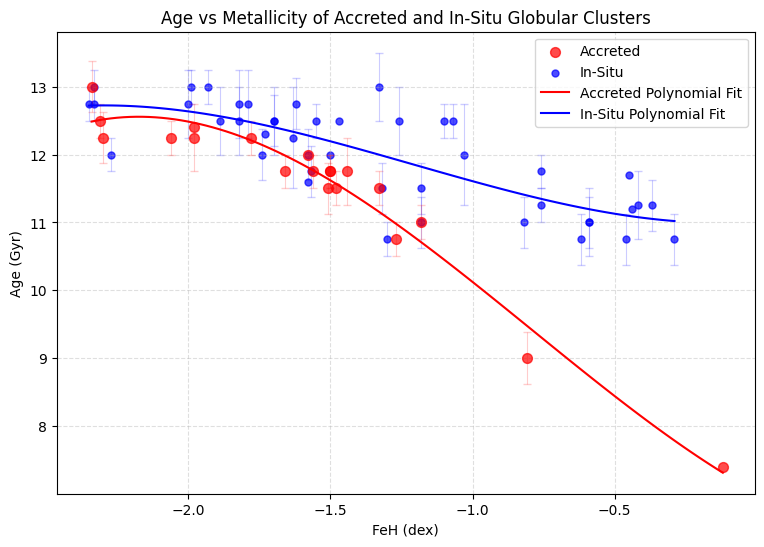

In [6]:

#mask = Accreted['ID'].isin(set_accreted)

fig, ax = plt.subplots(figsize=(9,6))
ax.scatter(Accreted['FeH'], Accreted['Age'], color='red', s=50 ,label='Accreted', zorder=2  , alpha=0.7, cmap='plasma')
ax.errorbar(Accreted['FeH'], Accreted['Age'], yerr=Accreted['Age_err'], fmt='none', ecolor='red', capsize=3, zorder=2, linewidth=0.8, alpha=0.2)
ax.scatter(InSitu['FeH'], InSitu['Age'], color='blue',s=25 ,label='In-Situ', zorder=1, alpha=0.7,cmap='plasma')
ax.errorbar(InSitu['FeH'], InSitu['Age'], yerr=InSitu['Age_err'], fmt='none', ecolor='blue', capsize=3, zorder=1, linewidth=0.8, alpha=0.2)
#ax.scatter(Accreted['FeH'], Accreted['Age'], yerr=Accreted['Age_err'], color='red', label='Accreted',zorder=2)
#ax.scatter(InSitu['FeH'], InSitu['Age'],yerr=Accreted["Age_err"], color='blue', label='In-Situ',zorder=1)

#polynomial fit
ax.grid(True, ls='--', alpha=0.4)

coeffs = np.polyfit(Accreted['FeH'], Accreted['Age'], deg=3)
poly_func1 = np.poly1d(coeffs)
x_smooth1 = np.linspace(Accreted['FeH'].min(), Accreted['FeH'].max(), 100)
y_smooth1 = poly_func1(x_smooth1)
plt.plot(x_smooth1, y_smooth1, color='red', label='Accreted Polynomial Fit')

print("Accreted equation of fit")
print(poly_func1)


coeffs = np.polyfit(InSitu['FeH'], InSitu['Age'], deg=3)
poly_func = np.poly1d(coeffs)
x_smooth1 = np.linspace(InSitu['FeH'].min(), InSitu['FeH'].max(), 100)
y_smooth = poly_func(x_smooth1)
plt.plot(x_smooth1, y_smooth, color='blue', label='In-Situ Polynomial Fit')

print("In-Situ equation of fit")
print(poly_func)


# Add labels and legend
ax.set_xlabel('FeH (dex)')
ax.set_ylabel('Age (Gyr)')
ax.legend()
#ax.set_ylim(10, 14)

ax.set_title('Age vs Metallicity of Accreted and In-Situ Globular Clusters')

plt.show()





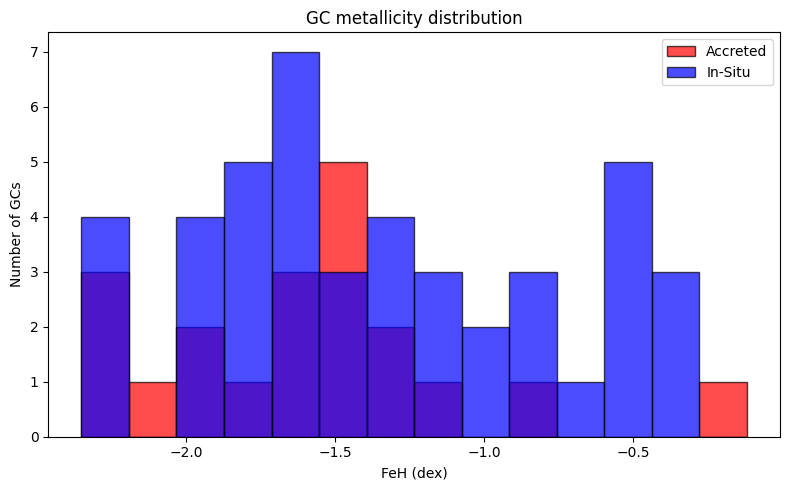

In [40]:
#ensure FeH column exists and drop NaNs
acc_feh = Accreted['FeH'].dropna()
ins_feh = InSitu['FeH'].dropna()

#bins
bins = np.linspace(min(acc_feh.min(), ins_feh.min()), max(acc_feh.max(), ins_feh.max()), 15)

fig , ax = plt.subplots(figsize=(8,5))

ax.hist(acc_feh, bins=bins, alpha=0.7, label='Accreted', color='red' ,  edgecolor='black')
ax.hist(ins_feh, bins=bins, alpha=0.7, label='In-Situ', color='blue', edgecolor='black')

ax.set_xlabel('FeH (dex)')
ax.set_ylabel('Number of GCs')
ax.set_title('GC metallicity distribution')
ax.legend()
plt.tight_layout()
plt.show()


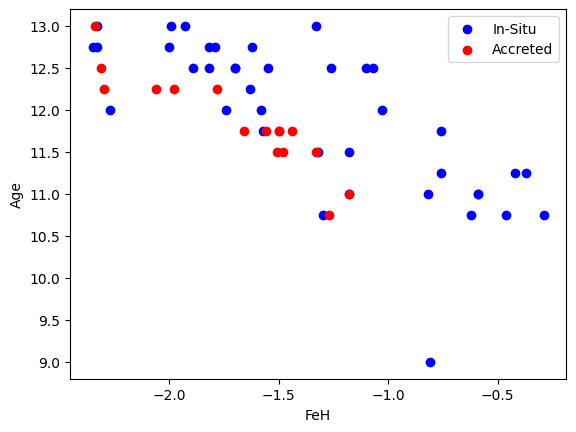

In [41]:
# Create a mask for IDs in int_accreted
mask = VandenBerg['#NGC'].isin(set_accreted)

# Create the figure and axis
fig, ax = plt.subplots()

# Plot non-accreted stars (blue)
ax.scatter(VandenBerg.loc[~mask,'FeH'], VandenBerg.loc[~mask, 'Age'],color='blue', label='In-Situ')

# Plot accreted stars (red)
ax.scatter(VandenBerg.loc[mask, 'FeH'], VandenBerg.loc[mask, 'Age'], color='red', label='Accreted')

# Add labels and legend
ax.set_xlabel('FeH')
ax.set_ylabel('Age')
ax.legend()


#VandenBerg.plot(kind = 'scatter', x ='FeH',y='Age')

In [42]:
orbits_galpy = Orbit.from_name('MW Globular Clusters')
names = []
apo = []
zmax = []
ecc = []


#time array for integration
ts = np.linspace(0, 100, 50000)     
orbits_galpy.integrate(ts, MWPotential2014, method='dopr54_c')
#calculate orbital parameters
for orb in orbits_galpy:    
    names.append(orb.name)
    apo.append(orb.rap(pot=MWPotential2014))
    zmax.append(orb.zmax(pot=MWPotential2014))  
    ecc.append(orb.e(pot=MWPotential2014))

names = np.array(names)
apo = np.array(apo, dtype=float)


#manual name corrections
names = ["NGCTer8" if name == "Terzan8" else name for name in names]
names = ["Ruprecht106" if name == "Rup106" else name for name in names]
names = ["NGCPal12" if name == "Pal12" else name for name in names]

# Create dictionaries for mapping
apo_dict   = dict(zip(names, apo))
zmax_dict  = dict(zip(names, zmax))
ecc_dict   = dict(zip(names, ecc))

# Map
InSitu['apo']  = InSitu['ID'].map(apo_dict)
InSitu['zmax'] = InSitu['ID'].map(zmax_dict)
InSitu['ecc']  = InSitu['ID'].map(ecc_dict)
Accreted['apo']  = Accreted['ID'].map(apo_dict)
Accreted['zmax'] = Accreted['ID'].map(zmax_dict)
Accreted['ecc']  = Accreted['ID'].map(ecc_dict)






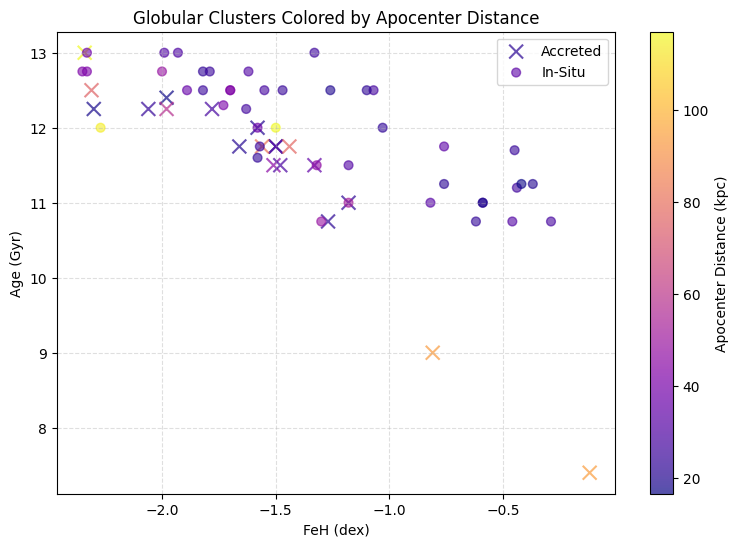

In [ ]:

fig, ax = plt.subplots(figsize=(9,6))
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sc = ax.scatter( Accreted['FeH'],Accreted['Age'], c=Accreted['apo'], cmap='plasma',marker='x',  s=100,  alpha=0.7,label='Accreted')
sc2 = ax.scatter(InSitu['FeH'], InSitu['Age'],c=InSitu['apo'], cmap='plasma',s=40,alpha=0.6,marker='o',label='In-Situ')


# Axis labels
ax.legend()
ax.set_xlabel('FeH (dex)')
ax.set_ylabel('Age (Gyr)')
ax.set_title('Globular Clusters Colored by Apocenter Distance')
ax.grid(True, ls='--', alpha=0.4)

# Add colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Apocenter Distance (kpc)')


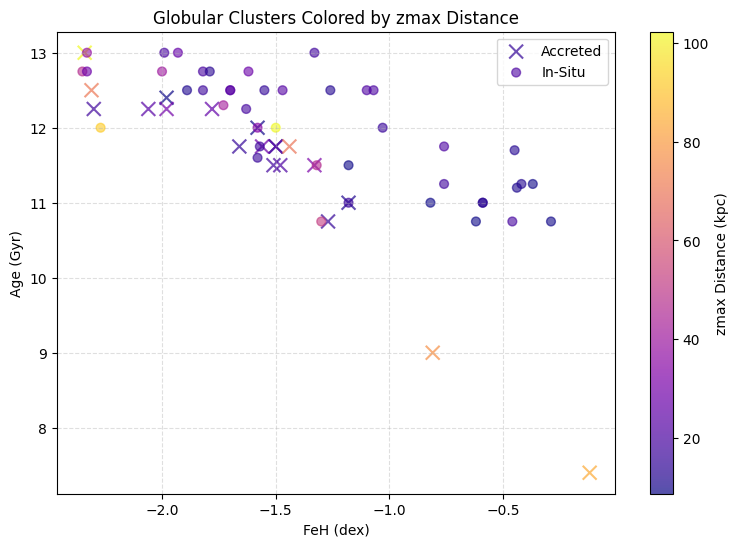

In [45]:

fig, ax = plt.subplots(figsize=(9,6))
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sc = ax.scatter( Accreted['FeH'],Accreted['Age'], c=Accreted['zmax'], cmap='plasma',marker='x',  s=100,  alpha=0.7,label='Accreted')
sc2 = ax.scatter(InSitu['FeH'], InSitu['Age'],c=InSitu['zmax'], cmap='plasma',s=40,alpha=0.6,marker='o',label='In-Situ')


# Axis labels
ax.legend()
ax.set_xlabel('FeH (dex)')
ax.set_ylabel('Age (Gyr)')
ax.set_title('Globular Clusters Colored by zmax Distance')
ax.grid(True, ls='--', alpha=0.4)

# Add colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('zmax Distance (kpc)')

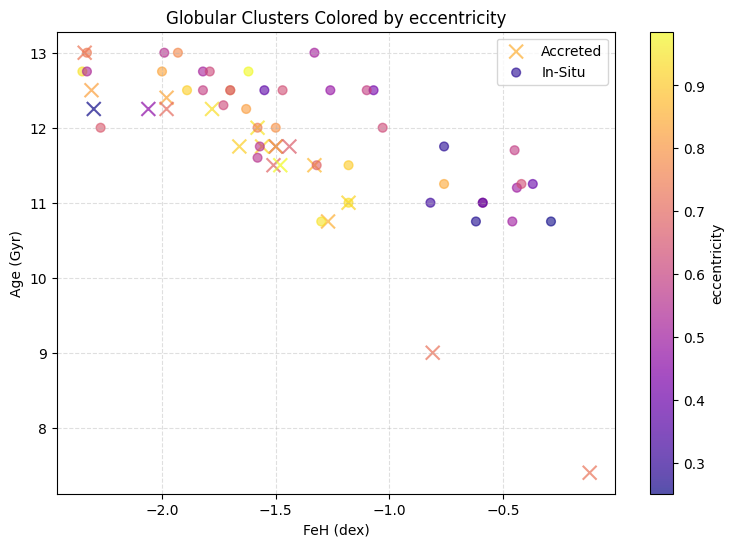

In [54]:


fig, ax = plt.subplots(figsize=(9,6))
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sc = ax.scatter( Accreted['FeH'],Accreted['Age'], c=Accreted['ecc'], cmap='plasma',marker='x',  s=100,  alpha=0.7,label='Accreted')
sc2 = ax.scatter(InSitu['FeH'], InSitu['Age'],c=InSitu['ecc'], cmap='plasma',s=40,alpha=0.6,marker='o',label='In-Situ')


# Axis labels
ax.legend()
ax.set_xlabel('FeH (dex)')
ax.set_ylabel('Age (Gyr)')
ax.set_title('Globular Clusters Colored by eccentricity')
ax.grid(True, ls='--', alpha=0.4)

# Add colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('eccentricity')

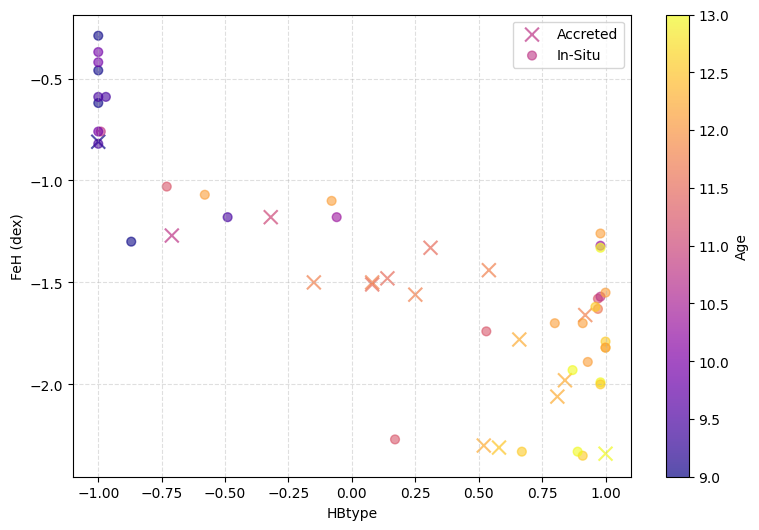

In [5]:

fig, ax = plt.subplots(figsize=(9,6))
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sc = ax.scatter( Accreted['HBtype'],Accreted['FeH'], c=Accreted['Age'], cmap='plasma',marker='x',  s=100,  alpha=0.7,label='Accreted')
sc2 = ax.scatter(InSitu['HBtype'], InSitu['FeH'],c=InSitu['Age'], cmap='plasma',s=40,alpha=0.6,marker='o',label='In-Situ')


# Axis labels
ax.legend()
ax.set_xlabel('HBtype')
ax.set_ylabel('FeH (dex)')
ax.set_title('')
ax.grid(True, ls='--', alpha=0.4)

# Add colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Age')

In [56]:
# replace 'FeH' with your metallicity column name if different
ids_list = Accreted.loc[
    pd.to_numeric(Accreted['FeH'], errors='coerce').between(-1.75, -1.0),
    'ID'
].tolist()

print(ids_list)
df_subset = Accreted.loc[Accreted['ID'].isin(ids_list)]
print(df_subset)



['NGC1261', 'NGC1851', 'NGC1904', 'NGC3201', 'NGC5272', 'NGC5904', 'NGC6584', 'NGC6715', 'NGC6934', 'NGC6981', 'NGC7089']
   Class  Mstar     rh    C5       ID  Age_err Method   Figs        Range  \
0     GC   3.41   5.50  0.62  NGC1261     0.25      V     13  10.75–11.25   
1     GC   5.51   3.05  1.81  NGC1851     0.25      V     13  10.75–11.25   
2     GC   1.45   4.10  0.50  NGC1904      NaN    NaN    NaN          NaN   
4     GC   1.10   7.50  0.15  NGC3201     0.38      A  12-30  11.25–11.75   
8     GC   4.68  11.70  0.40  NGC5272     0.25      V     22          NaN   
10    GC   3.89   6.60  0.59  NGC5904     0.25      V      8  11.50–11.75   
12    GC   3.03   4.87  0.62  NGC6584     0.25      A  12-30          NaN   
13    GC  12.90  10.70  1.20  NGC6715     0.50      V     32          NaN   
14    GC   2.95   5.32  0.55  NGC6934     0.25      V  12-30  11.50–12.00   
15    GC   1.68   7.82  0.21  NGC6981     0.25      V  12-30  11.25–11.75   
16    GC   5.75   6.03  0.95  N

##Age metalicity relation

It shows two clearly seperated sequences forming from the accreted and in-situ GCs. The in-situ clusters lie on a metal-rich branch whereas the accreted clusters lie on the metal poor branch (seen as the insitu have a higher FeH at a given age). This bifurcation was also found in previous works such as VandenBerg 2013 where they found that in-situ GCs where several Gyrs older at a fixed FeH. 

#orbital parameters
The accreted set shows a higher eccentricity while the in-situ have more circular orbits reflecting their origin in a rotating disk. The Accreted also include GCs with a high apocentric and zmax distance while all in-situ have a low apocentric and zmax distance.

##Spin up signature

spin up is the point where the milky way transitioned from a random spheroidal halo into a flattened rotating disk. The age metalicity plot reveals the spin up signuature around the point FeH = -1 where the in-situ polynomial starts to flatten. This flattening means that after this metalicity the MW could rapidly enrich its gas without much delay between generations of clusters which is a hallmark of a well mixed rotating disk. In other words before FeH = -1 the galaxy was still building mass and enriching slowly but after the galaxy is showing to had "spun up" into a disk. This corresponds to about 12Gyrs ago.

Before the spin-up transition FeH <-1 we can see that the eccentricities are high, the zmaxes and apocentric distances are also higher. 